<a href="https://colab.research.google.com/github/sudevansujit/Movie_Sentiment_Analysis/blob/master/Movie_Sentiment_Deep_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text Classification - Deep Learning Sequential Models - LSTMs"

In [2]:
# Code to read csv file into colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [3]:
downloaded = drive.CreateFile({'id':'1asZyLVRZ3QjWG4Pek-dAYYl9Kq9XZn3n'}) # replace the id with id of file you want to access
downloaded.GetContentFile('Cleaned_Movie_Review.csv')

In [4]:
import pandas as pd
import numpy as np

data = pd.read_csv('Cleaned_Movie_Review.csv', index_col = 'Unnamed: 0')
data.head()

,review,sentiment,new_review
0,one of the other reviewers has mentioned that ...,1,one reviewers mentioned watching oz episode ho...
1,a wonderful little production the filming tech...,1,wonderful little production filming technique ...
2,i thought this was a wonderful way to spend ti...,1,thought wonderful way spend time hot summer we...
3,basically there s a family where a little boy ...,0,basically family little boy jake thinks zombie...
4,petter mattei s love in the time of money is a...,1,petter mattei s love time money visually stunn...


In [5]:
# build train and test datasets
X_review = data['new_review'].values
y_sentiment = data['sentiment'].values

X_train = X_review[:35000]
y_train = y_sentiment[:35000]

X_test = X_review[35000:]
y_test = y_sentiment[35000:]

X_train.shape, y_train.shape

((35000,), (35000,))

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
import tensorflow as tf
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

"""To prepare text data for our deep learning model, we transform each review 
into a sequence. Every word in the review is mapped to an integer index and thus 
the sentence turns into a sequence of numbers.

To perform this transformation, keras provides the Tokenizer"""

In [7]:
t = Tokenizer(oov_token='<UNK>')
# fit the tokenizer on the documents
t.fit_on_texts(X_train)
t.word_index['<PAD>'] = 0


In [8]:
max([(k, v) for k, v in t.word_index.items()], key = lambda x:x[1])
    
min([(k, v) for k, v in t.word_index.items()], key = lambda x:x[1])
        
t.word_index['<UNK>']


1

In [9]:
       
train_sequences = t.texts_to_sequences(X_train)
test_sequences = t.texts_to_sequences(X_test)

print("Vocabulary size={}".format(len(t.word_index)))
print("Number of Documents={}".format(t.document_count))


Vocabulary size=87543
Number of Documents=35000


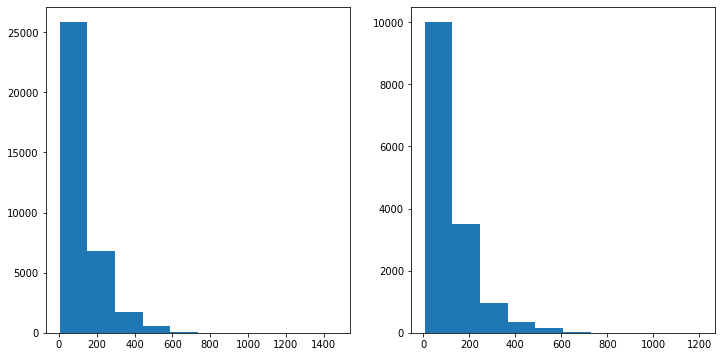

In [10]:
import matplotlib.pyplot as plt
#%matplotlib inline

train_lens = [len(s) for s in train_sequences]
test_lens = [len(s) for s in test_sequences]

fig, ax = plt.subplots(1,2, figsize=(12, 6))
h1 = ax[0].hist(train_lens)
h2 = ax[1].hist(test_lens)


# Sequence Normalization
"""Not all reviews are of same length. To handle this difference in length of 
reviews, we define a maximum length. For reviews which are smaller than this 
length, we pad them with zeros which longer ones are truncated"""

In [11]:
MAX_SEQUENCE_LENGTH = 600

# pad dataset to a maximum review length in words
X_train_1 = sequence.pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_test_1 = sequence.pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_train_1.shape, X_test_1.shape

((35000, 600), (15000, 600))

In [12]:
VOCAB_SIZE = len(t.word_index)
VOCAB_SIZE

87543

"""Another new and interesting approach to supervised deep learning is the use of 
recurrent neural networks (RNNs) and long short-term memory networks (LSTMs) which 
also considers the sequence of data (words, events and so on). These are more 
advanced models than your regular fully connected deep networks and usually take 
more time to train."""

# LSTM Model
#Build Model Architecture
#Embeddings

"""The Embedding layer helps us generate the word embeddings from scratch. This 
layer is also initialized with some weights and is updated based on our optimizer,
 similar to weights on the neuron units in other layers when the network tries 
 to minimize the loss in each epoch. Thus, the embedding layer tries to optimize
 its weights such that we get the best word embeddings that will generate minimum 
 error in the model and capture semantic similarity and relationships among words.
 How do we get the embeddings? Let’s say we have a review with three terms 
 ['movie', 'was', 'good'] and a vocab_map consisting of word to index mappings 
 for 175860 words."""

# LSTM
 
"""LSTMs try to overcome the shortcomings of RNN models, especially with regard 
to handling long-term dependencies and problems that occur when the weight matrix 
associated with the units (neurons) become too small (leading to vanishing gradient)
 or too large (leading to exploding gradient). These architectures are more complex
 than regular deep networks and going into detailed internals and math concepts 
 are out of the current scope, but we will try to cover the essentials here without
 making it math heavy"""

In [13]:
EMBEDDING_DIM = 300 # dimension for dense embeddings for each token
LSTM_DIM = 128 # total LSTM units

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH))
model.add(tf.keras.layers.SpatialDropout1D(0.1))
model.add(tf.keras.layers.LSTM(LSTM_DIM, return_sequences=False))
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation="sigmoid"))

model.compile(loss="binary_crossentropy", optimizer="adam",
              metrics=["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 600, 300)          26262900  
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 600, 300)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 128)               219648    
_________________________________________________________________
dense (Dense)                (None, 256)               33024     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 26,515,829
Trainable params: 26,515,829
Non-trainable params: 0
_________________________________________________________________


In [14]:
#Train Model

batch_size = 128
EPOCHS = 10

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                      patience=2,
                                      restore_best_weights=True,
                                      verbose=1)


In [15]:
history = model.fit(X_train_1, 
                    y_train, 
                    epochs=10, 
                    batch_size=batch_size, 
                    callbacks=[es],
                    shuffle=True, 
                    validation_split=0.1, 
                    verbose=1)


Epoch 1/10
247/247 [==============================] - 84s 341ms/step - loss: 0.3746 - accuracy: 0.8314 - val_loss: 0.3445 - val_accuracy: 0.8520
Epoch 2/10
247/247 [==============================] - 84s 340ms/step - loss: 0.1535 - accuracy: 0.9438 - val_loss: 0.3299 - val_accuracy: 0.8766
Epoch 3/10
247/247 [==============================] - 84s 338ms/step - loss: 0.0889 - accuracy: 0.9697 - val_loss: 0.3942 - val_accuracy: 0.8694
Epoch 4/10
247/247 [==============================] - 84s 340ms/step - loss: 0.0498 - accuracy: 0.9836 - val_loss: 0.4812 - val_accuracy: 0.8463
Epoch 00004: early stopping


In [16]:
# Evaluate Model Performance
# Final evaluation of the model
scores = model.evaluate(X_test_1, y_test, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

469/469 [==============================] - 7s 15ms/step - loss: 0.3144 - accuracy: 0.8812
Accuracy: 88.12%


In [17]:
predictions = model.predict_classes(X_test_1).ravel()
predictions[:10]

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


array([0, 1, 0, 1, 1, 0, 1, 1, 0, 1], dtype=int32)

In [18]:
from sklearn.metrics import confusion_matrix, classification_report

labels = ['negative', 'positive']
print(classification_report(y_test, predictions))
pd.DataFrame(confusion_matrix(y_test, predictions), index=labels, columns=labels)



              precision    recall  f1-score   support

           0       0.91      0.84      0.88      7490
           1       0.86      0.92      0.89      7510

    accuracy                           0.88     15000
   macro avg       0.88      0.88      0.88     15000
weighted avg       0.88      0.88      0.88     15000



,negative,positive
negative,6322,1168
positive,614,6896


In [19]:
#Thanks